In [2]:
from diffusers import StableDiffusionInpaintPipeline
import torch
import os
from PIL import Image
from IPython.display import display # to display images
import numpy as np
import scanpy as sc
import PIL.ImageOps
import pandas as pd
from sklearn.preprocessing import minmax_scale

Load up the data set - change to the scanpy data set of your choice.  This particular one was from this data set of mouse samples: https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSM6918972 provided by Morgan G Anderson-Crannage at New York Medical College.

In [3]:
adata = sc.read_h5ad('GSM6918972_WT1.h5ad')
adata

AnnData object with n_obs × n_vars = 4391 × 55421
    obs: 'TotalUMIs'
    var: 'Accession', 'AccessionVersion', 'Aliases', 'CcdsID', 'Chromosome', 'ChromosomeEnd', 'ChromosomeStart', 'CosmicID', 'DnaBindingDomain', 'FullName', 'GeneType', 'HgncID', 'IsTFi (TcoF-DB)', 'Location', 'LocationSortable', 'LocusGroup', 'LocusType', 'MgdID', 'MirBaseID', 'OmimID', 'PubmedID', 'RefseqID', 'Regulates (TRRUST)', 'RgdID', 'Strand', 'UcscID', 'UniprotID', 'VegaID'
    layers: 'matrix', 'spliced', 'unspliced'

Depending on what already exists in the scanpy data object, you might not have to redo the clustering and umap generation.  In that case, you can just run the very last line to re-show the data.

         Falling back to preprocessing with `sc.pp.pca` and default params.


C:\Users\Jonathan\anaconda3\envs\diffusion\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:369: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
C:\Users\Jonathan\anaconda3\envs\diffusion\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:379: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
C:\Users\Jonathan\anaconda3\envs\diffusion\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


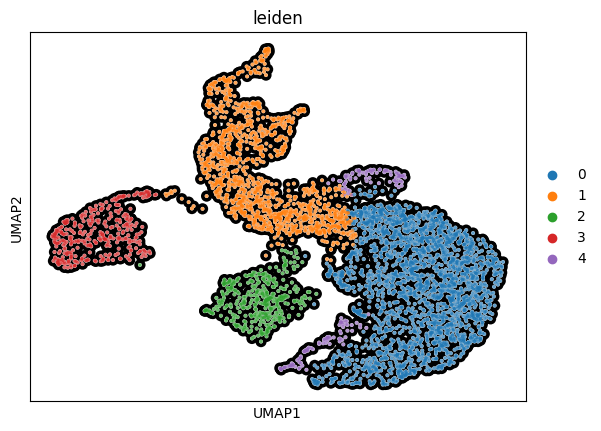

In [4]:
sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.tl.leiden(adata, resolution=0.1)
sc.pl.umap(adata, color = 'leiden', add_outline=True, outline_width=(1, 0.05), save=".png")

Extract the clusters and show them individually as images. You can tinkering with the size and outline_width parameters here to get nice filled shapes suitable for masks.

0


C:\Users\Jonathan\anaconda3\envs\diffusion\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:369: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
C:\Users\Jonathan\anaconda3\envs\diffusion\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:379: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
C:\Users\Jonathan\anaconda3\envs\diffusion\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


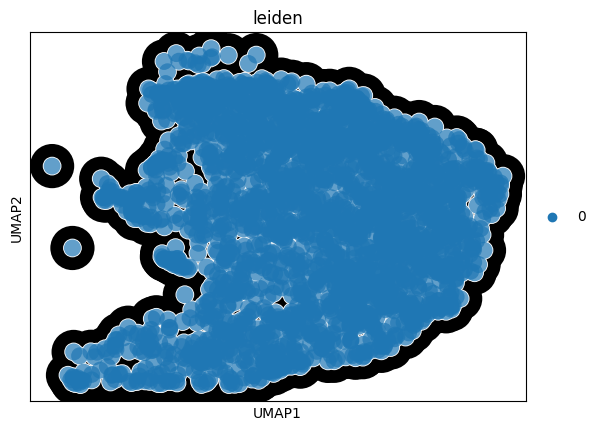

1


C:\Users\Jonathan\anaconda3\envs\diffusion\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:369: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
C:\Users\Jonathan\anaconda3\envs\diffusion\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:379: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
C:\Users\Jonathan\anaconda3\envs\diffusion\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


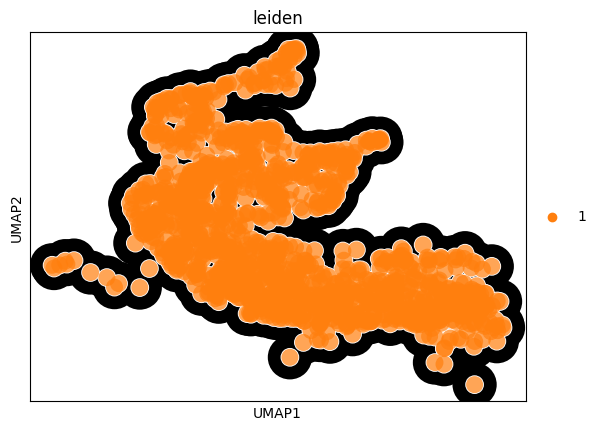

2


C:\Users\Jonathan\anaconda3\envs\diffusion\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:369: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
C:\Users\Jonathan\anaconda3\envs\diffusion\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:379: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
C:\Users\Jonathan\anaconda3\envs\diffusion\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


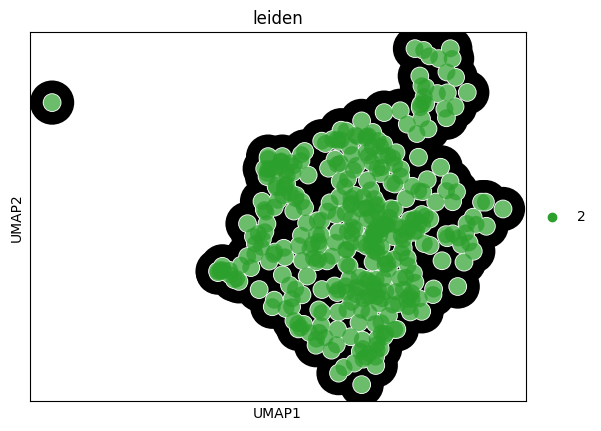

3


C:\Users\Jonathan\anaconda3\envs\diffusion\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:369: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
C:\Users\Jonathan\anaconda3\envs\diffusion\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:379: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
C:\Users\Jonathan\anaconda3\envs\diffusion\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


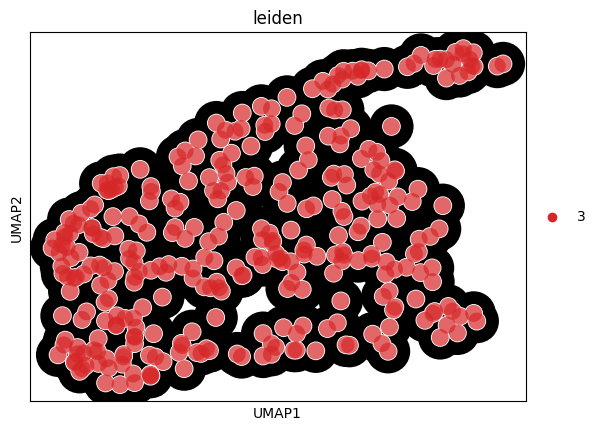

4


C:\Users\Jonathan\anaconda3\envs\diffusion\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:369: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
C:\Users\Jonathan\anaconda3\envs\diffusion\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:379: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
C:\Users\Jonathan\anaconda3\envs\diffusion\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


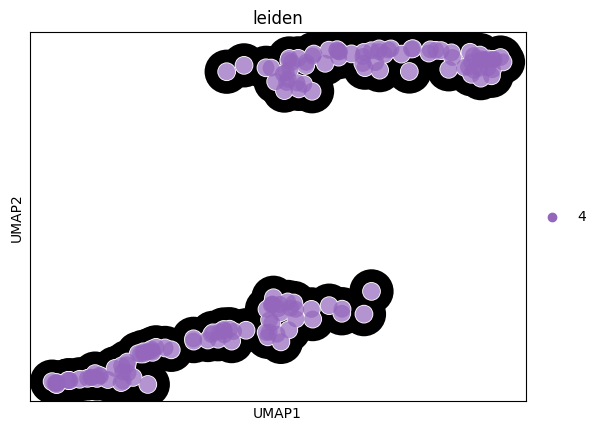

In [5]:
clusters = sorted(list(set(adata.obs['leiden'])))
for c in clusters:
    clust_mk = np.in1d( adata.obs['leiden'], [c])
    new_adata = adata[clust_mk]
    print(c)
    sc.pl.umap(new_adata, color = 'leiden', size=600,add_outline=True, outline_width=(0.75, 0.05), save=c + '.png')


Now, step through the clusters again and convert them to black and white images, to be later used as masks

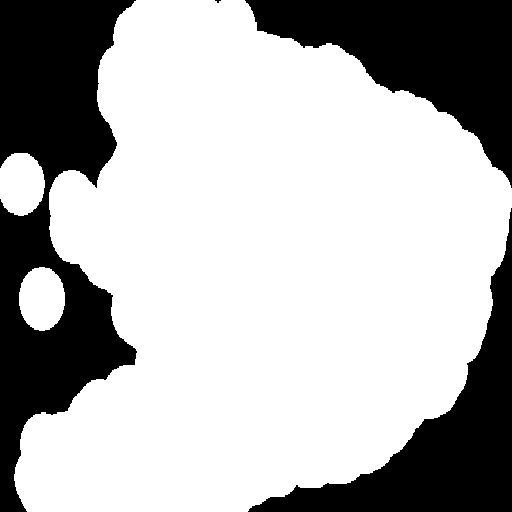

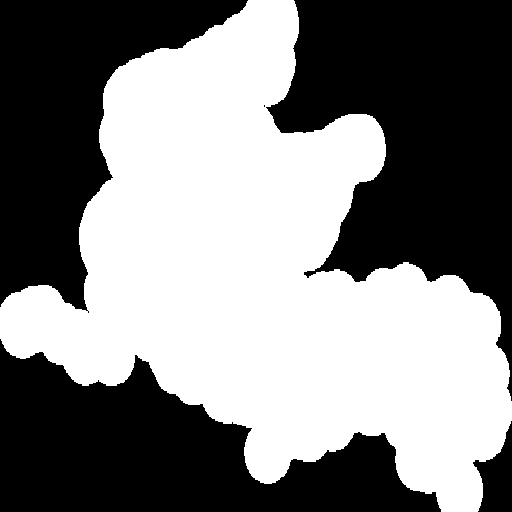

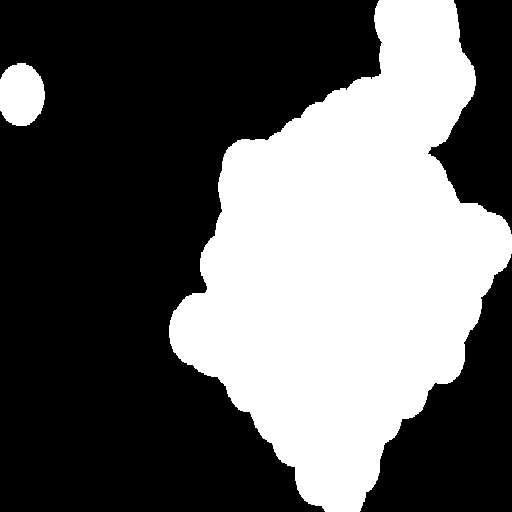

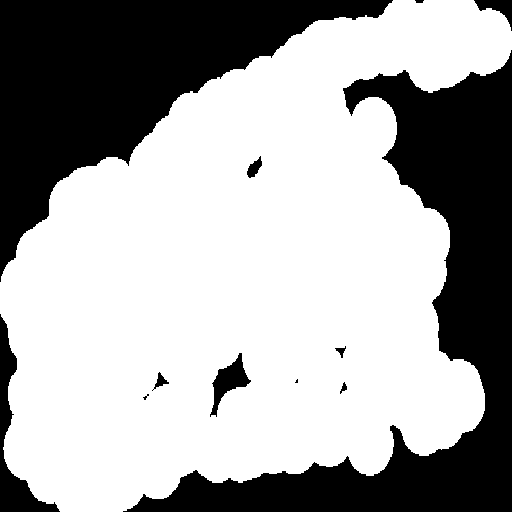

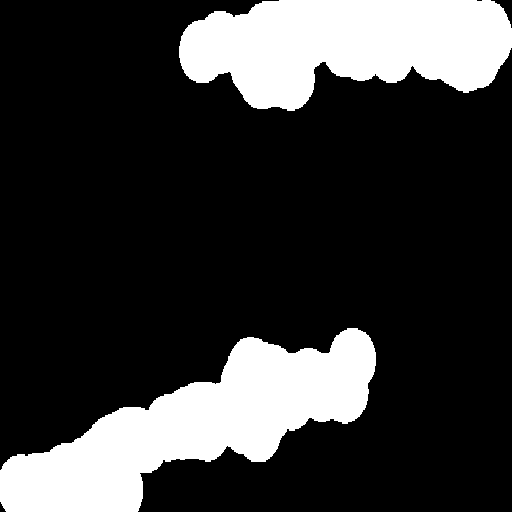

In [6]:
masks = []
for c in clusters:
    cluster = Image.open(r"figures\\umap" + c +".png")
    thresh = 250
    fn = lambda x : 255 if x > thresh else 0
    cluster = cluster.convert('L').point(fn, mode='1')
    cluster = cluster.crop((32, 35, 525, 400))
    cluster = cluster.resize((512,512), Image.Resampling.LANCZOS)
    cluster = PIL.ImageOps.invert(cluster)
    masks.append(cluster)
    display(cluster.resize((100,100)))

Now, this part will take a bit of creativity.  Think about what appear in the different clusters and provide prompts. Try to specify colors to add a bit of contrast.

In [7]:
prompts = ['a sitting rainbow-colored frog',
          'a majestic jet-black pegasus',
          'a blueish-grey bunny rabbit',
          'a curled up orange cat',
          'two facing yellow koi fish']
prompts = dict(zip(clusters, prompts))
masks = dict(zip(clusters, masks))

Load up a generic white image to serve as a background

#torch.cuda.is_available()
torch.rand(10).to(device)
torch.cuda.get_device_name(0)
device = torch.device('cuda')
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

In [8]:
whiteImage = PIL.Image.new(mode="RGB", size=(512, 512), color=(255,255,255))
#whiteImage = whiteImage.resize((512,512), Image.Resampling.LANCZOS)


Load up the stable diffusion model.  I'm making some compromises here to get it to run on a card with limited memory.  But if you aren't resource-constrained, feel free to use a pipeline that swings for the fences a bit more!

In [11]:
pipe = StableDiffusionInpaintPipeline.from_pretrained(
    "runwayml/stable-diffusion-inpainting",
    revision="fp16",
    torch_dtype=torch.float16,
)
pipe.to('cuda')
pipe.enable_attention_slicing()

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

C:\Users\Jonathan\anaconda3\envs\diffusion\lib\site-packages\transformers\models\clip\feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(


Actually generate the images. Set attempts as high as you'd like, given your processing power and patience :-)

a sitting rainbow-colored frog, space-filling, full color, high resolution, white background


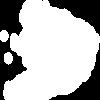

  0%|          | 0/50 [00:00<?, ?it/s]

Attempt 0 on cluster 0


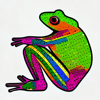

  0%|          | 0/50 [00:00<?, ?it/s]

Attempt 1 on cluster 0


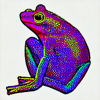

  0%|          | 0/50 [00:00<?, ?it/s]

Attempt 2 on cluster 0


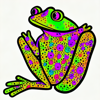

  0%|          | 0/50 [00:00<?, ?it/s]

Attempt 3 on cluster 0


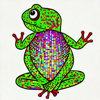

  0%|          | 0/50 [00:00<?, ?it/s]

Attempt 4 on cluster 0


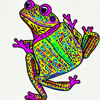

  0%|          | 0/50 [00:00<?, ?it/s]

Attempt 5 on cluster 0


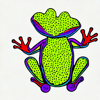

  0%|          | 0/50 [00:00<?, ?it/s]

Attempt 6 on cluster 0


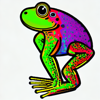

  0%|          | 0/50 [00:00<?, ?it/s]

Attempt 7 on cluster 0


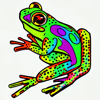

  0%|          | 0/50 [00:00<?, ?it/s]

Attempt 8 on cluster 0


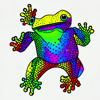

  0%|          | 0/50 [00:00<?, ?it/s]

Attempt 9 on cluster 0


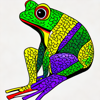

  0%|          | 0/50 [00:00<?, ?it/s]

Attempt 10 on cluster 0


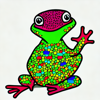

  0%|          | 0/50 [00:00<?, ?it/s]

Attempt 11 on cluster 0


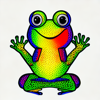

  0%|          | 0/50 [00:00<?, ?it/s]

Attempt 12 on cluster 0


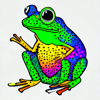

  0%|          | 0/50 [00:00<?, ?it/s]

Attempt 13 on cluster 0


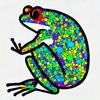

  0%|          | 0/50 [00:00<?, ?it/s]

Attempt 14 on cluster 0


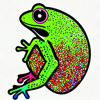

  0%|          | 0/50 [00:00<?, ?it/s]

Attempt 15 on cluster 0


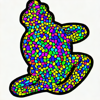

  0%|          | 0/50 [00:00<?, ?it/s]

Attempt 16 on cluster 0


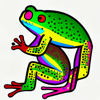

  0%|          | 0/50 [00:00<?, ?it/s]

Attempt 17 on cluster 0


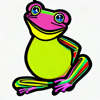

  0%|          | 0/50 [00:00<?, ?it/s]

Attempt 18 on cluster 0


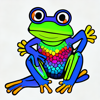

  0%|          | 0/50 [00:00<?, ?it/s]

Attempt 19 on cluster 0


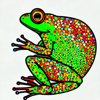

  0%|          | 0/50 [00:00<?, ?it/s]

Attempt 20 on cluster 0


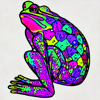

  0%|          | 0/50 [00:00<?, ?it/s]

Attempt 21 on cluster 0


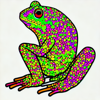

  0%|          | 0/50 [00:00<?, ?it/s]

Attempt 22 on cluster 0


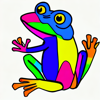

  0%|          | 0/50 [00:00<?, ?it/s]

Attempt 23 on cluster 0


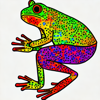

  0%|          | 0/50 [00:00<?, ?it/s]

Attempt 24 on cluster 0


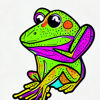

  0%|          | 0/50 [00:00<?, ?it/s]

Attempt 25 on cluster 0


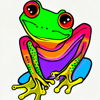

  0%|          | 0/50 [00:00<?, ?it/s]

Attempt 26 on cluster 0


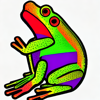

  0%|          | 0/50 [00:00<?, ?it/s]

Attempt 27 on cluster 0


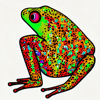

  0%|          | 0/50 [00:00<?, ?it/s]

Attempt 28 on cluster 0


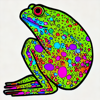

  0%|          | 0/50 [00:00<?, ?it/s]

Attempt 29 on cluster 0


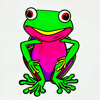

a majestic jet-black pegasus, space-filling, full color, high resolution, white background


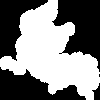

  0%|          | 0/50 [00:00<?, ?it/s]

Attempt 0 on cluster 1


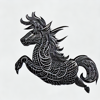

  0%|          | 0/50 [00:00<?, ?it/s]

Attempt 1 on cluster 1


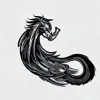

  0%|          | 0/50 [00:00<?, ?it/s]

Attempt 2 on cluster 1


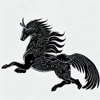

  0%|          | 0/50 [00:00<?, ?it/s]

Attempt 3 on cluster 1


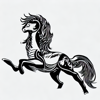

  0%|          | 0/50 [00:00<?, ?it/s]

Attempt 4 on cluster 1


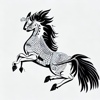

  0%|          | 0/50 [00:00<?, ?it/s]

Attempt 5 on cluster 1


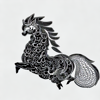

  0%|          | 0/50 [00:00<?, ?it/s]

Attempt 6 on cluster 1


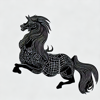

  0%|          | 0/50 [00:00<?, ?it/s]

Attempt 7 on cluster 1


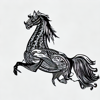

  0%|          | 0/50 [00:00<?, ?it/s]

Attempt 8 on cluster 1


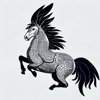

  0%|          | 0/50 [00:00<?, ?it/s]

Attempt 9 on cluster 1


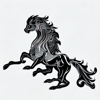

  0%|          | 0/50 [00:00<?, ?it/s]

Attempt 10 on cluster 1


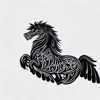

  0%|          | 0/50 [00:00<?, ?it/s]

Attempt 11 on cluster 1


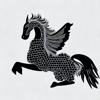

  0%|          | 0/50 [00:00<?, ?it/s]

Attempt 12 on cluster 1


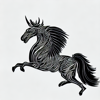

  0%|          | 0/50 [00:00<?, ?it/s]

Attempt 13 on cluster 1


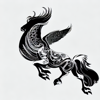

  0%|          | 0/50 [00:00<?, ?it/s]

Attempt 14 on cluster 1


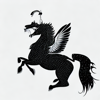

  0%|          | 0/50 [00:00<?, ?it/s]

Attempt 15 on cluster 1


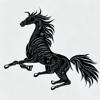

  0%|          | 0/50 [00:00<?, ?it/s]

Attempt 16 on cluster 1


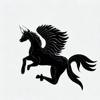

  0%|          | 0/50 [00:00<?, ?it/s]

Attempt 17 on cluster 1


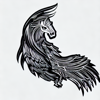

  0%|          | 0/50 [00:00<?, ?it/s]

Attempt 18 on cluster 1


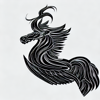

  0%|          | 0/50 [00:00<?, ?it/s]

Attempt 19 on cluster 1


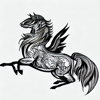

  0%|          | 0/50 [00:00<?, ?it/s]

Attempt 20 on cluster 1


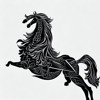

  0%|          | 0/50 [00:00<?, ?it/s]

Attempt 21 on cluster 1


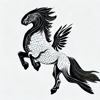

  0%|          | 0/50 [00:00<?, ?it/s]

Attempt 22 on cluster 1


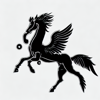

  0%|          | 0/50 [00:00<?, ?it/s]

Attempt 23 on cluster 1


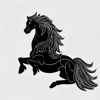

  0%|          | 0/50 [00:00<?, ?it/s]

Attempt 24 on cluster 1


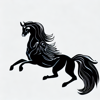

  0%|          | 0/50 [00:00<?, ?it/s]

Attempt 25 on cluster 1


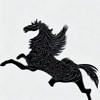

  0%|          | 0/50 [00:00<?, ?it/s]

Attempt 26 on cluster 1


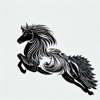

  0%|          | 0/50 [00:00<?, ?it/s]

Attempt 27 on cluster 1


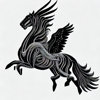

  0%|          | 0/50 [00:00<?, ?it/s]

Attempt 28 on cluster 1


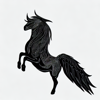

  0%|          | 0/50 [00:00<?, ?it/s]

Attempt 29 on cluster 1


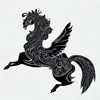

a blueish-grey bunny rabbit, space-filling, full color, high resolution, white background


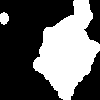

  0%|          | 0/50 [00:00<?, ?it/s]

Attempt 0 on cluster 2


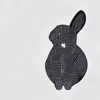

  0%|          | 0/50 [00:00<?, ?it/s]

Attempt 1 on cluster 2


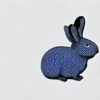

  0%|          | 0/50 [00:00<?, ?it/s]

Attempt 2 on cluster 2


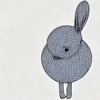

  0%|          | 0/50 [00:00<?, ?it/s]

Attempt 3 on cluster 2


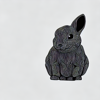

  0%|          | 0/50 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


Attempt 4 on cluster 2


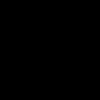

  0%|          | 0/50 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


Attempt 5 on cluster 2


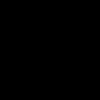

  0%|          | 0/50 [00:00<?, ?it/s]

Attempt 6 on cluster 2


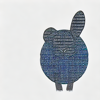

  0%|          | 0/50 [00:00<?, ?it/s]

Attempt 7 on cluster 2


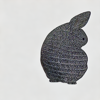

  0%|          | 0/50 [00:00<?, ?it/s]

Attempt 8 on cluster 2


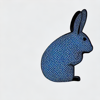

  0%|          | 0/50 [00:00<?, ?it/s]

Attempt 9 on cluster 2


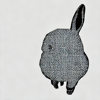

  0%|          | 0/50 [00:00<?, ?it/s]

Attempt 10 on cluster 2


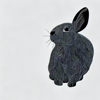

  0%|          | 0/50 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


Attempt 11 on cluster 2


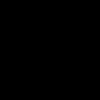

  0%|          | 0/50 [00:00<?, ?it/s]

Attempt 12 on cluster 2


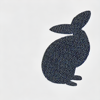

  0%|          | 0/50 [00:00<?, ?it/s]

Attempt 13 on cluster 2


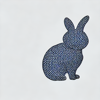

  0%|          | 0/50 [00:00<?, ?it/s]

Attempt 14 on cluster 2


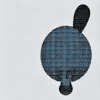

  0%|          | 0/50 [00:00<?, ?it/s]

Attempt 15 on cluster 2


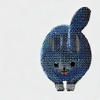

  0%|          | 0/50 [00:00<?, ?it/s]

Attempt 16 on cluster 2


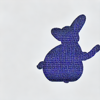

  0%|          | 0/50 [00:00<?, ?it/s]

Attempt 17 on cluster 2


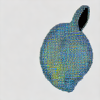

  0%|          | 0/50 [00:00<?, ?it/s]

Attempt 18 on cluster 2


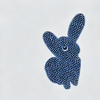

  0%|          | 0/50 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


Attempt 19 on cluster 2


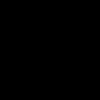

  0%|          | 0/50 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


Attempt 20 on cluster 2


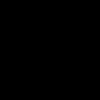

  0%|          | 0/50 [00:00<?, ?it/s]

Attempt 21 on cluster 2


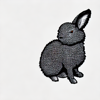

  0%|          | 0/50 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


Attempt 22 on cluster 2


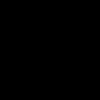

  0%|          | 0/50 [00:00<?, ?it/s]

Attempt 23 on cluster 2


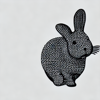

  0%|          | 0/50 [00:00<?, ?it/s]

Attempt 24 on cluster 2


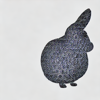

  0%|          | 0/50 [00:00<?, ?it/s]

Attempt 25 on cluster 2


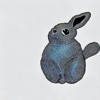

  0%|          | 0/50 [00:00<?, ?it/s]

Attempt 26 on cluster 2


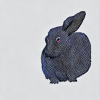

  0%|          | 0/50 [00:00<?, ?it/s]

Attempt 27 on cluster 2


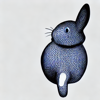

  0%|          | 0/50 [00:00<?, ?it/s]

Attempt 28 on cluster 2


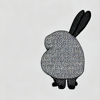

  0%|          | 0/50 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


Attempt 29 on cluster 2


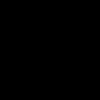

a curled up orange cat, space-filling, full color, high resolution, white background


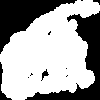

  0%|          | 0/50 [00:00<?, ?it/s]

Attempt 0 on cluster 3


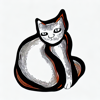

  0%|          | 0/50 [00:00<?, ?it/s]

Attempt 1 on cluster 3


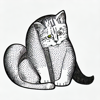

  0%|          | 0/50 [00:00<?, ?it/s]

Attempt 2 on cluster 3


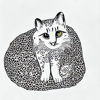

  0%|          | 0/50 [00:00<?, ?it/s]

Attempt 3 on cluster 3


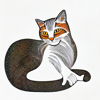

  0%|          | 0/50 [00:00<?, ?it/s]

Attempt 4 on cluster 3


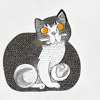

  0%|          | 0/50 [00:00<?, ?it/s]

Attempt 5 on cluster 3


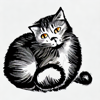

  0%|          | 0/50 [00:00<?, ?it/s]

Attempt 6 on cluster 3


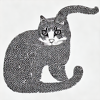

  0%|          | 0/50 [00:00<?, ?it/s]

Attempt 7 on cluster 3


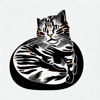

  0%|          | 0/50 [00:00<?, ?it/s]

Attempt 8 on cluster 3


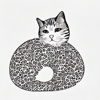

  0%|          | 0/50 [00:00<?, ?it/s]

Attempt 9 on cluster 3


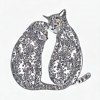

  0%|          | 0/50 [00:00<?, ?it/s]

Attempt 10 on cluster 3


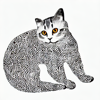

  0%|          | 0/50 [00:00<?, ?it/s]

Attempt 11 on cluster 3


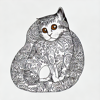

  0%|          | 0/50 [00:00<?, ?it/s]

Attempt 12 on cluster 3


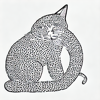

  0%|          | 0/50 [00:00<?, ?it/s]

Attempt 13 on cluster 3


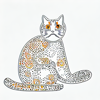

  0%|          | 0/50 [00:00<?, ?it/s]

Attempt 14 on cluster 3


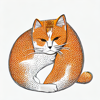

  0%|          | 0/50 [00:00<?, ?it/s]

Attempt 15 on cluster 3


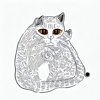

  0%|          | 0/50 [00:00<?, ?it/s]

Attempt 16 on cluster 3


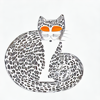

  0%|          | 0/50 [00:00<?, ?it/s]

Attempt 17 on cluster 3


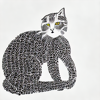

  0%|          | 0/50 [00:00<?, ?it/s]

Attempt 18 on cluster 3


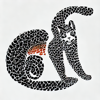

  0%|          | 0/50 [00:00<?, ?it/s]

Attempt 19 on cluster 3


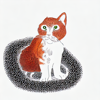

  0%|          | 0/50 [00:00<?, ?it/s]

Attempt 20 on cluster 3


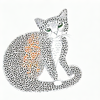

  0%|          | 0/50 [00:00<?, ?it/s]

Attempt 21 on cluster 3


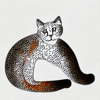

  0%|          | 0/50 [00:00<?, ?it/s]

Attempt 22 on cluster 3


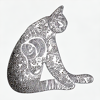

  0%|          | 0/50 [00:00<?, ?it/s]

Attempt 23 on cluster 3


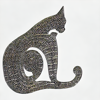

  0%|          | 0/50 [00:00<?, ?it/s]

Attempt 24 on cluster 3


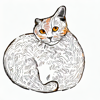

  0%|          | 0/50 [00:00<?, ?it/s]

Attempt 25 on cluster 3


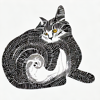

  0%|          | 0/50 [00:00<?, ?it/s]

Attempt 26 on cluster 3


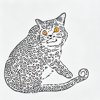

  0%|          | 0/50 [00:00<?, ?it/s]

Attempt 27 on cluster 3


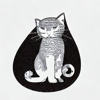

  0%|          | 0/50 [00:00<?, ?it/s]

Attempt 28 on cluster 3


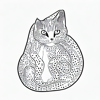

  0%|          | 0/50 [00:00<?, ?it/s]

Attempt 29 on cluster 3


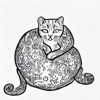

two facing yellow koi fish, space-filling, full color, high resolution, white background


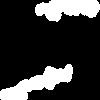

  0%|          | 0/50 [00:00<?, ?it/s]

Attempt 0 on cluster 4


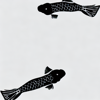

  0%|          | 0/50 [00:00<?, ?it/s]

Attempt 1 on cluster 4


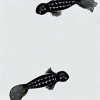

  0%|          | 0/50 [00:00<?, ?it/s]

Attempt 2 on cluster 4


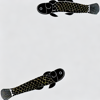

  0%|          | 0/50 [00:00<?, ?it/s]

Attempt 3 on cluster 4


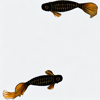

  0%|          | 0/50 [00:00<?, ?it/s]

Attempt 4 on cluster 4


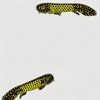

  0%|          | 0/50 [00:00<?, ?it/s]

Attempt 5 on cluster 4


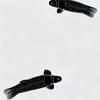

  0%|          | 0/50 [00:00<?, ?it/s]

Attempt 6 on cluster 4


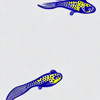

  0%|          | 0/50 [00:00<?, ?it/s]

Attempt 7 on cluster 4


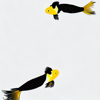

  0%|          | 0/50 [00:00<?, ?it/s]

Attempt 8 on cluster 4


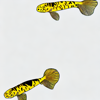

  0%|          | 0/50 [00:00<?, ?it/s]

Attempt 9 on cluster 4


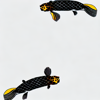

  0%|          | 0/50 [00:00<?, ?it/s]

Attempt 10 on cluster 4


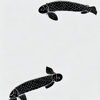

  0%|          | 0/50 [00:00<?, ?it/s]

Attempt 11 on cluster 4


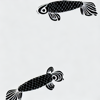

  0%|          | 0/50 [00:00<?, ?it/s]

Attempt 12 on cluster 4


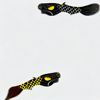

  0%|          | 0/50 [00:00<?, ?it/s]

Attempt 13 on cluster 4


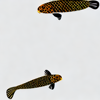

  0%|          | 0/50 [00:00<?, ?it/s]

Attempt 14 on cluster 4


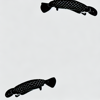

  0%|          | 0/50 [00:00<?, ?it/s]

Attempt 15 on cluster 4


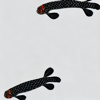

  0%|          | 0/50 [00:00<?, ?it/s]

Attempt 16 on cluster 4


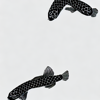

  0%|          | 0/50 [00:00<?, ?it/s]

Attempt 17 on cluster 4


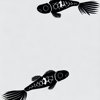

  0%|          | 0/50 [00:00<?, ?it/s]

Attempt 18 on cluster 4


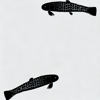

  0%|          | 0/50 [00:00<?, ?it/s]

Attempt 19 on cluster 4


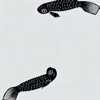

  0%|          | 0/50 [00:00<?, ?it/s]

Attempt 20 on cluster 4


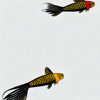

  0%|          | 0/50 [00:00<?, ?it/s]

Attempt 21 on cluster 4


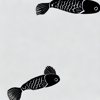

  0%|          | 0/50 [00:00<?, ?it/s]

Attempt 22 on cluster 4


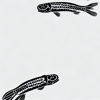

  0%|          | 0/50 [00:00<?, ?it/s]

Attempt 23 on cluster 4


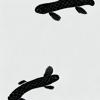

  0%|          | 0/50 [00:00<?, ?it/s]

Attempt 24 on cluster 4


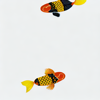

  0%|          | 0/50 [00:00<?, ?it/s]

Attempt 25 on cluster 4


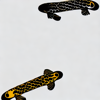

  0%|          | 0/50 [00:00<?, ?it/s]

Attempt 26 on cluster 4


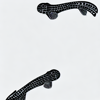

  0%|          | 0/50 [00:00<?, ?it/s]

Attempt 27 on cluster 4


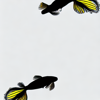

  0%|          | 0/50 [00:00<?, ?it/s]

Attempt 28 on cluster 4


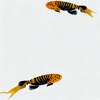

  0%|          | 0/50 [00:00<?, ?it/s]

Attempt 29 on cluster 4


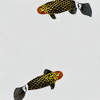

In [39]:

images = []

attempts= 30


for i in clusters:
    prompt = prompts[i] + ", space-filling, full color, high resolution, white background"
    mask_image = masks[i]
    print(prompt)
    display(mask_image.resize((100,100)))
    for j in range(0,attempts):
        image = pipe(prompt=prompt, image=whiteImage, mask_image=mask_image).images[0]
        image.save("./cluster-" + i + "-image-" + str(j)+ ".png")
        print("Attempt "+ str(j) + " on cluster " + str(i))
    
        display(image.resize((100,100)))

        images.append({'Cluster': i, 'Attempt': j, 'Unfilled': -1, 'Prompt': prompt, 'Result': image})
df = pd.DataFrame(images)

Calculate the unfilled space for each image. This will help later in selecting only those that best fill the spaces.

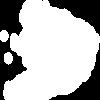

183711
0 0


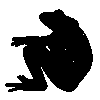

113869
38.01732068302932
0 1


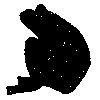

121505
33.860792222566964
0 2


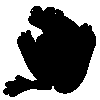

133858
27.136643967971434
0 3


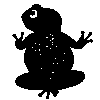

109266
40.52288649019384
0 4


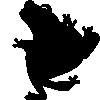

121033
34.117717501946
0 5


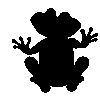

102907
43.98430142996337
0 6


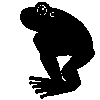

109663
40.30678620224156
0 7


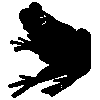

113405
38.26989129665616
0 8


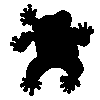

104783
42.96313231107555
0 9


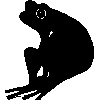

122217
33.473226970622335
0 10


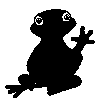

103552
43.6332065036933
0 11


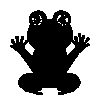

106039
42.27944978798221
0 12


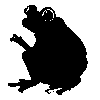

110258
39.982907936922665
0 13


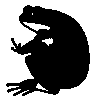

125026
31.944194958385726
0 14


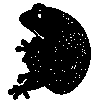

131960
28.169788417677765
0 15


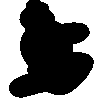

137842
24.968020423382377
0 16


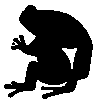

128910
29.830004735699006
0 17


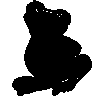

119295
35.063768636608586
0 18


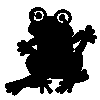

116722
36.46433800915568
0 19


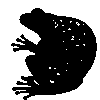

131821
28.245450735122013
0 20


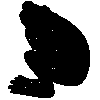

129144
29.70263076244754
0 21


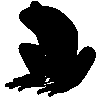

126535
31.122796130879475
0 22


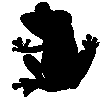

123765
32.63059914757418
0 23


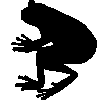

113347
38.30146262335952
0 24


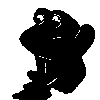

122459
33.34149833161869
0 25


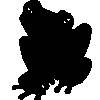

140381
23.585958380282072
0 26


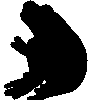

135473
26.257545819248712
0 27


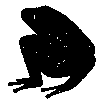

124624
32.163016912433115
0 28


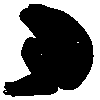

142185
22.603981253163937
0 29


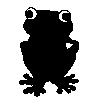

100630
45.22374816967955


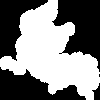

131961
1 0


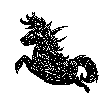

67179
49.09177711596608
1 1


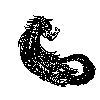

59681
54.77375891361842
1 2


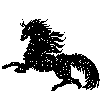

68664
47.96644463136836
1 3


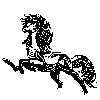

51106
61.27189093747395
1 4


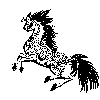

47200
64.23185638180978
1 5


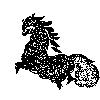

61047
53.738604587719095
1 6


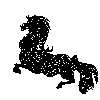

64999
50.7437803593486
1 7


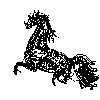

54413
58.76584748524185
1 8


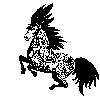

61200
53.62266124082116
1 9


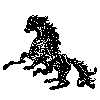

54774
58.49228181053493
1 10


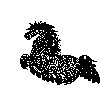

58152
55.93243458294496
1 11


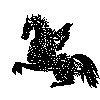

68955
47.74592493236638
1 12


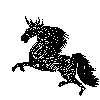

59343
55.029895196308
1 13


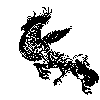

54550
58.66202893279075
1 14


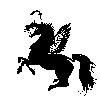

62209
52.85804139101704
1 15


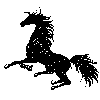

58588
55.602033934268455
1 16


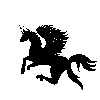

54479
58.71583270814862
1 17


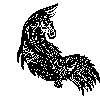

68623
47.9975144171384
1 18


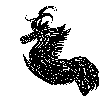

70530
46.55239047900516
1 19


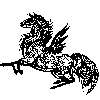

60669
54.02505285652579
1 20


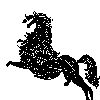

69409
47.40188388993718
1 21


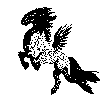

55670
57.81329332151166
1 22


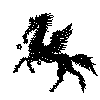

55519
57.927721069103754
1 23


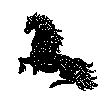

65601
50.28758496828608
1 24


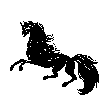

57094
56.73418661574253
1 25


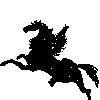

65788
50.1458764331886
1 26


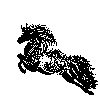

54595
58.627927948408995
1 27


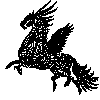

76358
42.13593410174219
1 28


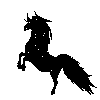

56839
56.92742552723911
1 29


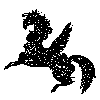

67438
48.895507005857795


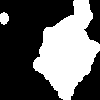

100685
2 0


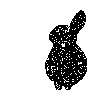

51017
49.33008889109599
2 1


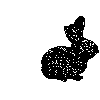

48061
52.265978050355066
2 2


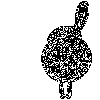

49265
51.070169340020854
2 3


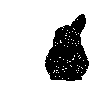

48565
51.76540696230819
2 4


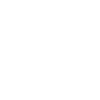

0
100.0
2 5


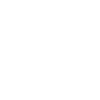

0
100.0
2 6


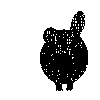

61753
38.66713015841486
2 7


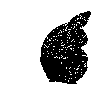

60440
39.97119729850524
2 8


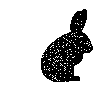

49686
50.652033570045184
2 9


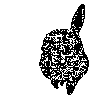

47473
52.84997765307643
2 10


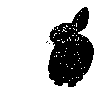

61668
38.751551869692605
2 11


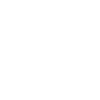

0
100.0
2 12


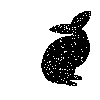

55585
44.793166807369516
2 13


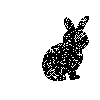

38121
62.13835228683517
2 14


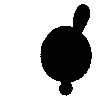

72960
27.53637582559468
2 15


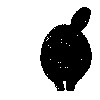

74384
26.122063862541587
2 16


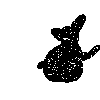

49580
50.75731240999156
2 17


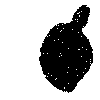

77358
23.1682971644237
2 18


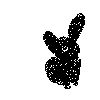

44930
55.375676615185974
2 19


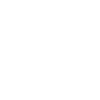

0
100.0
2 20


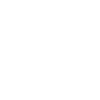

0
100.0
2 21


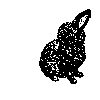

49901
50.43849630034265
2 22


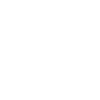

0
100.0
2 23


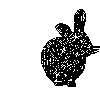

55788
44.59154789690619
2 24


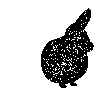

55858
44.52202413467746
2 25


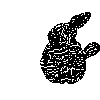

52857
47.50260714108357
2 26


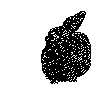

58975
41.4262303222923
2 27


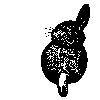

58392
42.00526394199732
2 28


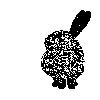

43989
56.3102746188608
2 29


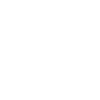

0
100.0


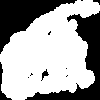

169763
3 0


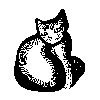

60396
64.42334313130658
3 1


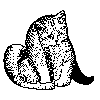

50959
69.98226939910346
3 2


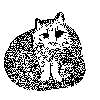

58756
65.38939580473955
3 3


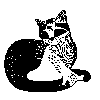

73557
56.670770427007064
3 4


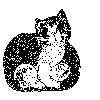

66798
60.652203365868885
3 5


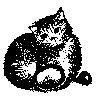

90406
46.745757320499756
3 6


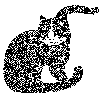

76847
54.73277451505923
3 7


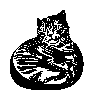

77240
54.50127530734024
3 8


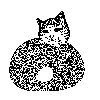

54533
67.87698143882943
3 9


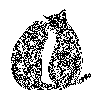

57244
66.28004924512409
3 10


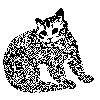

62122
63.40663159816921
3 11


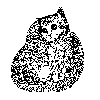

52848
68.86954165513097
3 12


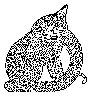

51816
69.47744797158391
3 13


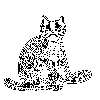

31038
81.71686409877299
3 14


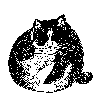

77818
54.16080064560593
3 15


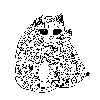

31210
81.61554637936416
3 16


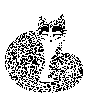

42504
74.96274217585693
3 17


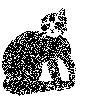

73802
56.526451582500314
3 18


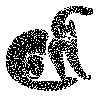

74323
56.219553141732895
3 19


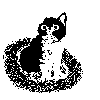

65709
61.2936859032887
3 20


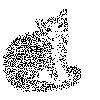

37817
77.72365002974735
3 21


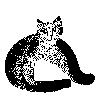

65239
61.57054246213839
3 22


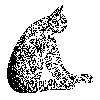

48542
71.4060189794007
3 23


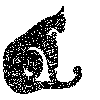

72588
57.24156618344398
3 24


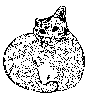

35294
79.20983959991283
3 25


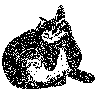

79771
53.01037328510924
3 26


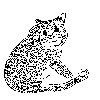

36538
78.47705330372342
3 27


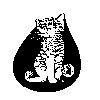

68320
59.75565936040245
3 28


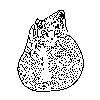

29980
82.34008588443889
3 29


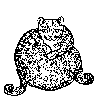

53536
68.46427077749568


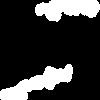

56818
4 0


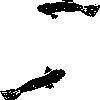

32859
42.167974937519794
4 1


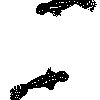

31511
44.540462529480095
4 2


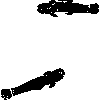

35528
37.47051990566369
4 3


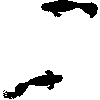

29565
47.965433489387166
4 4


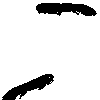

28697
49.49311837797881
4 5


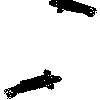

28437
49.95071984230349
4 6


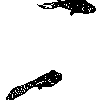

25708
54.75377521208068
4 7


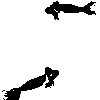

26217
53.85793234538351
4 8


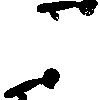

33911
40.31644901263684
4 9


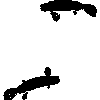

32893
42.10813474603119
4 10


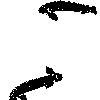

29856
47.45327185046992
4 11


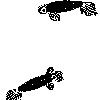

29660
47.79823295434545
4 12


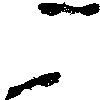

28102
50.540321729029536
4 13


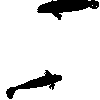

30061
47.09247069590622
4 14


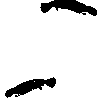

25204
55.64081805061776
4 15


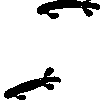

32454
42.8807772184871
4 16


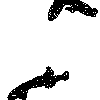

31858
43.92974057516984
4 17


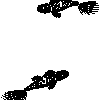

32040
43.60941955014256
4 18


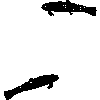

25826
54.546094547502555
4 19


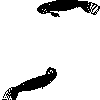

29771
47.602872329191456
4 20


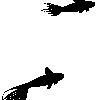

28033
50.66176211763877
4 21


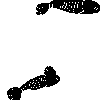

32682
42.47949593438699
4 22


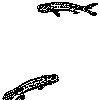

23666
58.347706712661484
4 23


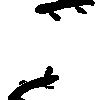

30741
45.89566686613397
4 24


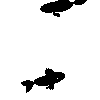

21814
61.607237143158855
4 25


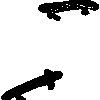

36340
36.041395332465065
4 26


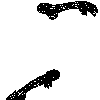

28743
49.41215811890598
4 27


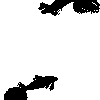

31322
44.8731035939315
4 28


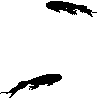

21525
62.115878770812074
4 29


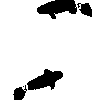

30618
46.11214755887219


In [75]:
adf = pd.DataFrame(images)
thresh = 240
fn = lambda x : 255 if x > thresh else 0
from PIL import ImageDraw
for i in clusters:
    mask_image = masks[i]
    testMask = np.array(mask_image)
    testMask = (np.sum(testMask == 1)) 
    display(mask_image.resize((100,100)))
    print(testMask)
    for j in range(0,attempts):
        print(i, j)
        image = adf[(adf['Cluster']==i)&(adf['Attempt']==j)]['Result'].values[0]
        image = addTransparency(image, mask_image).convert("RGB")
        ImageDraw.floodfill(image, (0,0), (255, 255, 255), thresh=100)
        ImageDraw.floodfill(image, (511,0), (255, 255, 255), thresh=100)
        ImageDraw.floodfill(image, (511,511), (255, 255, 255), thresh=100)
        ImageDraw.floodfill(image, (511,0), (255, 255, 255), thresh=100)
        binImage = image.convert('L').point(fn, mode='1')
        test = np.array(binImage)
        test = (np.sum(test == 0))
        unfilled = 100* ((testMask-test)/testMask)
        index = adf[(adf['Cluster']==i)&(adf['Attempt']==j)].index[0]
        adf.loc[index,'Unfilled'] = unfilled
        display(binImage.resize((100,100)))
        print(test)
        print(unfilled)

Return only the "most spacing" results.  You can adjust this part if you'd like to review different options.

In [103]:
keepVersion = 3
df = adf.copy()
df = df.sort_values(['Cluster', 'Unfilled'])
df = df.groupby(['Cluster']).agg(lambda x: x.iloc[keepVersion]).reset_index()
df

,Cluster,Attempt,Unfilled,Prompt,Result
0,0,26,26.257546,"a sitting rainbow-colored frog, space-filling,...",<PIL.Image.Image image mode=RGB size=512x512 a...
1,1,11,47.745925,"a majestic jet-black pegasus, space-filling, f...",<PIL.Image.Image image mode=RGB size=512x512 a...
2,2,6,38.667130,"a blueish-grey bunny rabbit, space-filling, fu...",<PIL.Image.Image image mode=RGB size=512x512 a...
3,3,7,54.501275,"a curled up orange cat, space-filling, full co...",<PIL.Image.Image image mode=RGB size=512x512 a...
4,4,9,42.108135,"two facing yellow koi fish, space-filling, ful...",<PIL.Image.Image image mode=RGB size=512x512 a...


Make a copy of the scanpy object to rescale for final output / cluster positions.  You could probably also just copy the umap matrix to save memory, although you'd also have to mess with the cluster subsetting later in the code.

In [104]:
sdata = adata.copy()
sdata.obsm['X_umap'][:, 1] = -sdata.obsm['X_umap'][:, 1]
sdata.obsm['X_umap'] = minmax_scale(sdata.obsm['X_umap'], feature_range=(0,1000)).astype(int)


Convenience function for adding one of the images on top of the existing image, with transparency for the internal data AND the mask

In [105]:
def addTransparency(img, mask):
    img = img.convert("RGBA")
    
    threshold = 200
    
    datas = img.getdata()
    newData = []
    for item in datas:
        if item[0] > threshold  and item[1] > threshold and item[2] > threshold:
            newData.append((255, 255, 255, 0))
        else:
            newData.append(item)
    img.putdata(newData)
    
    mask = PIL.ImageOps.invert(mask)
    mask = mask.convert("RGBA")
    datas = mask.getdata()
    newData = []
    for item in datas:
        if item[0] < 50  and item[1] < 50 and item[2] < 50:
            newData.append((255, 255, 255, 0))
        else:
            newData.append(item)
            
    mask.putdata(newData)


    mask.alpha_composite(img, dest=(0,0))

    return img


Stitch all those temporary images into one final image, respecting the spacing of the original clusters

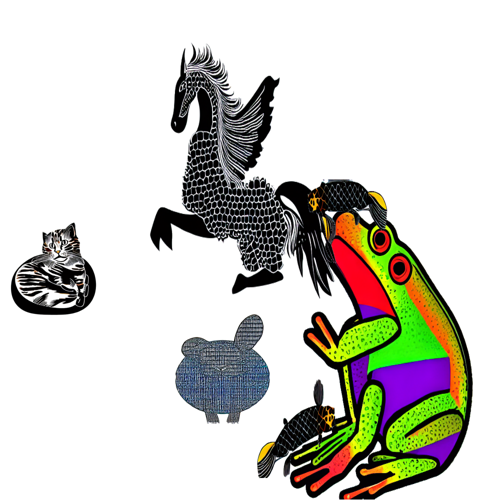

In [106]:
new = PIL.Image.new(mode="RGBA", size=(1000, 1000), color=(255,255,255,255))

for c in clusters:
    clust_mk = np.in1d( sdata.obs['leiden'], [c])
    new_adata = sdata[clust_mk].copy()
    clusterImage = df[df['Cluster']==c]['Result'].values[0]
    x1 = (np.min(new_adata.obsm['X_umap'],axis=0))[0]
    y1 = (np.min(new_adata.obsm['X_umap'],axis=0))[1]
    x2 = (np.max(new_adata.obsm['X_umap'],axis=0))[0]
    y2 = (np.max(new_adata.obsm['X_umap'],axis=0))[1]
    x_size = x2-x1
    y_size = y2-y1
    
    mask_image = masks[c]
    clusterImage = addTransparency(clusterImage, mask_image)
    clusterImage = clusterImage.resize((x_size, y_size))
    
    clusterImage = clusterImage.convert("RGBA")
    
    new.alpha_composite(clusterImage, dest=(x1, y1))
display(new.resize((500,500)))
new.save("./finalImage" + str(keepVersion) + ".png")